In [153]:
# Lib imports
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras import regularizers  # Add at the top with imports
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt


In [154]:
# DATASET DIRECTORY CONFIGURATION
# Download and unzip the dataset from Kaggle, set the directory paths accordingly.
train_dir = "Cats_Dogs_Mini_Datasets/train"  # e.g. './muffin-vs-chihuahua/train'
test_dir = "Cats_Dogs_Mini_Datasets/test"    # e.g. './muffin-vs-chihuahua/test'

In [42]:
import os
print(os.listdir('Cats_Dogs_Mini_Datasets/PetImages'))


['cats_set', 'dogs_set']


In [155]:
# IMAGE PARAMETERS
# Used to resize the input images, also will determine the input size of your input layer.
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

In [156]:
# DATA PREPROCESSING & AUGMENTATION
# Optional but recommended for image processing tasks, especially with limited data.
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=['cats_set', 'dogs_set'], # correct label ordering
    subset='training'
)
val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    #classes=['cats_set', 'dogs_set'],
    subset='validation'
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    #classes=['cats_set', 'dogs_set'],
    shuffle=False
)

Found 600 images belonging to 2 classes.
Found 149 images belonging to 2 classes.
Found 749 images belonging to 2 classes.


In [157]:
# SIMPLE CNN MODEL ARCHITECTURE

# Some modifications are applied
initial_learning_rate = 0.0008
# We are combining ExponentialDecay with Adam optimizer for better learning rate management
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True
)

# Create the optimizer with the learning rate schedule
# optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)

# Applied dropout layers to reduce overfitting
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.20),
    
    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.20),
    
    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.20),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

In [158]:
# Configure the model optimizers, loss function, and metrics
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # old
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [172]:
# TRAINING THE CNN

# early_stop = EarlyStopping(
#     monitor='val_loss',  # watch the validation loss
#     patience=5,          # stop if no improvement for 5 epochs
#     restore_best_weights=True  # restore weights from the best epoch
# )

history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
   # callbacks=[early_stop]  # add the callback here
)

Epoch 1/20
19/19 [==============================] - 9s 480ms/step - loss: 1.0441 - accuracy: 0.6883 - val_loss: 3.1013 - val_accuracy: 0.6711
Epoch 2/20
19/19 [==============================] - 9s 451ms/step - loss: 1.0278 - accuracy: 0.6800 - val_loss: 2.4859 - val_accuracy: 0.6711
Epoch 3/20
19/19 [==============================] - 9s 453ms/step - loss: 1.0150 - accuracy: 0.6967 - val_loss: 2.3640 - val_accuracy: 0.6711
Epoch 4/20
19/19 [==============================] - 9s 491ms/step - loss: 0.9976 - accuracy: 0.6950 - val_loss: 3.2321 - val_accuracy: 0.6711
Epoch 5/20
19/19 [==============================] - 11s 565ms/step - loss: 0.9801 - accuracy: 0.7333 - val_loss: 2.7902 - val_accuracy: 0.6644
Epoch 6/20
19/19 [==============================] - 10s 543ms/step - loss: 1.0392 - accuracy: 0.6917 - val_loss: 2.6225 - val_accuracy: 0.6711
Epoch 7/20
19/19 [==============================] - 11s 563ms/step - loss: 1.0227 - accuracy: 0.6933 - val_loss: 3.0023 - val_accuracy: 0.6711
Epo

In [173]:
# EVALUATE THE MODEL
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc}")

24/24 [==============================] - 3s 111ms/step - loss: 1.4345 - accuracy: 0.7343
Test Accuracy: 0.7343124151229858


In [174]:
# SAVE THE MODEL
model.save('exercise_6_custom_escrupulo-porras.h5')

In [177]:
def predict_image(img_path, model_path='exercise_6_custom_escrupulo-porras.h5'):
    # Load model
    model = tf.keras.models.load_model(model_path)
    
    # Load and preprocess image
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img) / 255.0
    img_array_exp = np.expand_dims(img_array, axis=0)
    
    # Predict
    pred = model.predict(img_array_exp)[0,0]
    label = "Cat" if pred >= 0.5 else "Dog"
    
    # Display the image
    # plt.imshow(img)
    # plt.axis('off')
    # plt.title(f"Prediction: {label}\nConfidence: {pred:.2f}")
    # plt.show()
    plt.imshow(img)
    plt.title(f"Prediction: {label}\nConfidence: {pred:.2f}")
    plt.axis('off')
    plt.show()

1/1 [==============================] - 0s 165ms/step


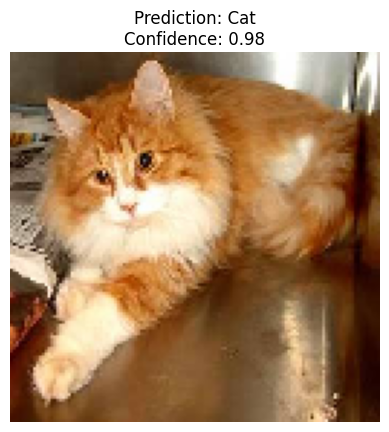

1/1 [==============================] - 0s 167ms/step


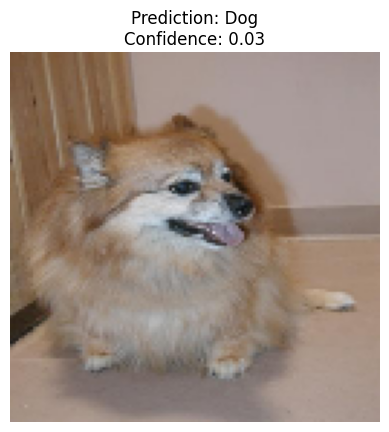

In [178]:
# # Example usage:
# predict_image("muffin-vs-chihuahua/test_1/chihuahua/img_4_226.jpg")
# predict_image("muffin-vs-chihuahua/test_1/muffin/img_3_711.jpg")

predict_image("Cats_Dogs_Mini_Datasets/test/cats_set/cat.4052.jpg",
              model_path='exercise_6_custom_escrupulo-porras.h5')

predict_image("Cats_Dogs_Mini_Datasets/test/dogs_set/967.jpg",
              model_path='exercise_6_custom_escrupulo-porras.h5')

In [164]:
print(train_generator.class_indices)


{'cats_set': 0, 'dogs_set': 1}
